In [92]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import datetime
from datetime import timedelta, datetime
from sklearn.cluster import MeanShift, KMeans
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
import math
import requests
import io
import warnings
   

from matplotlib import pyplot as plt
%matplotlib inline
warnings.simplefilter("ignore")

In [3]:
url = 'https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&limit=unlimited&lang=ru'

In [4]:
req = requests.get(url)
s = req.content
encoding = req.encoding

In [5]:
df = pd.read_csv(io.StringIO(s.decode(encoding)), sep=';', header=1)

In [6]:
df.head()

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,...,RTL3,RTH3,DISCOUNT1,LIMIT1,DISCOUNT2,LIMIT2,DISCOUNT3,DISCOUNTL0,DISCOUNTH0,FULLCOVERED
0,AMUNIBB2AER2,UBANK11/22,UNIBANK OJSC Series 1,Корпоративные еврооблигации,AMUNIBB2AER2,NaN,3.0,"100,0",USD,10000.0,...,"0,0","12182,3","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
1,AMUNIBB2DER6,UBANK02/24,UNIBANK OJSC Series 1 21,Корпоративные еврооблигации,AMUNIBB2DER6,NaN,3.0,"100,0",USD,33478.0,...,"0,0","12339,24","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
2,AT0000A2UF10,Raiff CAG,Raiffeisen Centrobank AG,Корпоративные еврооблигации,AT0000A2UF10,NaN,3.0,"1000,0",USD,50000.0,...,"0,0","101387,58","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
3,CH0248531110,VTB-24 CHF,VTB CAPITAL S.A. 24 CHF,Корпоративные еврооблигации,CH0248531110,NaN,NaN,"5000,0",CHF,70000.0,...,"0,0","645115,16","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
4,CH0379268748,RZD-23 CHF,RZD Capital PLC 23 CHF,Корпоративные еврооблигации,CH0379268748,NaN,NaN,"5000,0",CHF,90000.0,...,"0,0","393947,82","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0


In [7]:
# Оставим только рублевые облигации с заполненной ставкой купона и датой начала торгов
df = df[(df.FACEUNIT == 'RUB') & (df.COUPONPERCENT.notnull()) & (df.ISSUEDATE.notnull())].copy()
df.shape

(2071, 54)

In [8]:
# Преобразуем некоторые признаки в формат datetime
df['MATDATE']= pd.to_datetime(df['MATDATE'])
df['COUPONDATE']= pd.to_datetime(df['COUPONDATE'])
df['ISSUEDATE']= pd.to_datetime(df['ISSUEDATE'])
df['STARTDATEMOEX']= pd.to_datetime(df['STARTDATEMOEX'])
df['OFFERDATE']= pd.to_datetime(df['OFFERDATE'])

In [9]:
# Преобразуем числовые признаки в float
df['COUPONPERCENT'] = df['COUPONPERCENT'].str.replace(',', '.').astype(float)
df['FACEVALUE'] = df['FACEVALUE'].str.replace(',', '.').astype(float)
df['INITIALFACEVALUE'] = df['INITIALFACEVALUE'].str.replace(',', '.').astype(float)
df['COUPONVALUE'] = df['COUPONVALUE'].str.replace(',', '.').astype(float)
df['YIELDATWAP'] = df['YIELDATWAP'].str.replace(',', '.').astype(float)
df['PRICE'] = df['PRICE'].str.replace(',', '.').astype(float)
df['PRICE_RUB'] = df['PRICE_RUB'].str.replace(',', '.').astype(float)
df['RTL1'] = df['RTL1'].str.replace(',', '.').astype(float)
df['RTH1'] = df['RTH1'].str.replace(',', '.').astype(float)
df['RTL2'] = df['RTL2'].str.replace(',', '.').astype(float)
df['RTH2'] = df['RTH2'].str.replace(',', '.').astype(float)
df['RTL3'] = df['RTL3'].str.replace(',', '.').astype(float)
df['RTH3'] = df['RTH3'].str.replace(',', '.').astype(float)

In [10]:
# Установим дату погашения, равной дате оферты, если она указана. 
df['MATDATE'] = df[['MATDATE','OFFERDATE']].apply(lambda x: x.MATDATE if x.OFFERDATE is np.NaN else x.OFFERDATE, axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2071 entries, 12 to 2657
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   SECID                   2071 non-null   object        
 1   SHORTNAME               2071 non-null   object        
 2   NAME                    2071 non-null   object        
 3   TYPENAME                2071 non-null   object        
 4   ISIN                    2071 non-null   object        
 5   REGNUMBER               2006 non-null   object        
 6   LISTLEVEL               2056 non-null   float64       
 7   FACEVALUE               2071 non-null   float64       
 8   FACEUNIT                2071 non-null   object        
 9   ISSUESIZE               2071 non-null   float64       
 10  IS_COLLATERAL           2071 non-null   int64         
 11  IS_EXTERNAL             2071 non-null   int64         
 12  PRIMARY_BOARDID         2071 non-null   object 

## -----------------------------------------------------------------
Далее по заданию
1.	Оценить рынок рублевых облигаций по распределению купонной доходности

Если будем смотреть непосредственно ставку купона:
## ------------------------------------------------------------------

In [12]:
# Найдём выборочное среднее, дисперию, стандартное отклонение, медиану и моду.

mu = np.mean(df.COUPONPERCENT)
var = np.var(df.COUPONPERCENT)
std = np.std(df.COUPONPERCENT)
median = np.median(df.COUPONPERCENT)
moda = stats.mode(df.COUPONPERCENT)[0][0]
print('Выборочное среднее = %.4f' % mu)
print('Дисперсия = %.4f' % var)
print('Стандартное отклонение = %.4f' % std)
print('Медиана = %.4f' % median)
print('Мода = %.4f' % moda)

Выборочное среднее = 6.8864
Дисперсия = 25.7550
Стандартное отклонение = 5.0749
Медиана = 7.6000
Мода = 0.0100


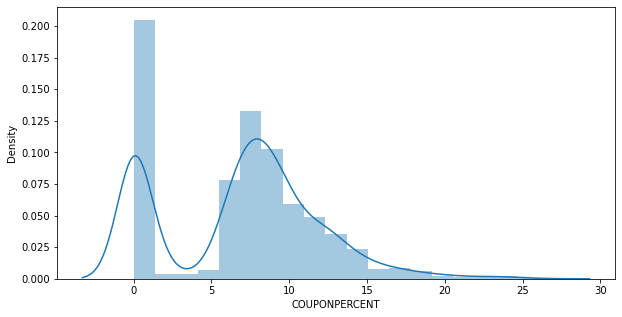

In [13]:
# Построим гистограмму и ядерную оценку плотности

fig = plt.figure(figsize=(10, 5))

sns.distplot(df.COUPONPERCENT);

На графике видим два максимума. Значение ставки купона 0,01 сильно отличается от распределения остальных значений ставки. Посмотрим подробнее на наиболее часть встречающиеся значения ставки.

In [14]:
df.COUPONPERCENT.value_counts().head(10)

0.01     489
12.00     39
13.00     37
9.50      31
10.00     30
11.00     29
12.50     28
9.00      26
8.00      26
7.50      24
Name: COUPONPERCENT, dtype: int64

Видим, что действительно купонов со ставкой 0,01 на порядок больше, чем купонов с остальными ставками. Поищем, чем быть обусловлено.

[]

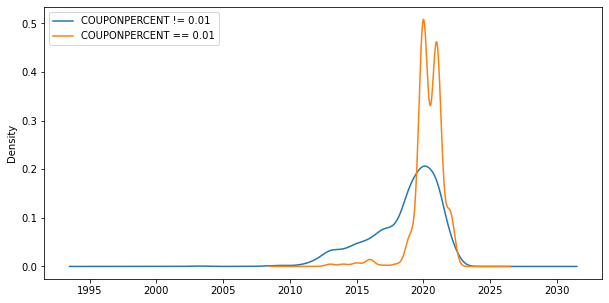

In [15]:
# Посмотрим, может зависит от даты выпуска
fig = plt.figure(figsize=(10, 5))

df[df.COUPONPERCENT != 0.01]['ISSUEDATE'].apply(lambda x: x.year).plot(kind='density', label='COUPONPERCENT != 0.01')
df[df.COUPONPERCENT == 0.01]['ISSUEDATE'].apply(lambda x: x.year).plot(kind='density', label='COUPONPERCENT == 0.01')

plt.legend()
plt.plot()

Явной зависимости от года выпуска не видим. Посмотрим зависимость от категориальных признаков.

In [16]:
# Введем флаг по COUPONPERCENT = 0.01
df['flag_001'] = df.COUPONPERCENT.apply(lambda x: 1 if x==0.01 else 0)

In [17]:
cat_col = ['TYPENAME','LISTLEVEL','IS_COLLATERAL','PRIMARY_BOARDID','HIGH_RISK','COUPONFREQUENCY']

df[cat_col].isnull().sum()

TYPENAME             0
LISTLEVEL           15
IS_COLLATERAL        0
PRIMARY_BOARDID      0
HIGH_RISK            0
COUPONFREQUENCY    321
dtype: int64

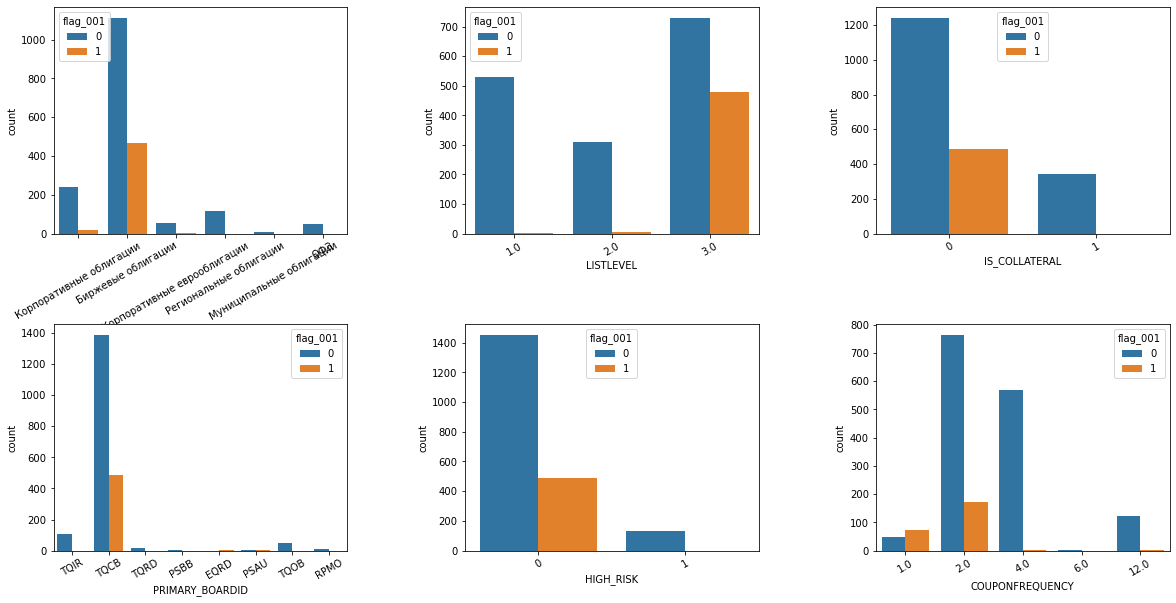

In [18]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, col in enumerate(cat_col):
    plt.subplot(2,3,i+1)
    sns.countplot(x=df[col], hue=df['flag_001'])
    plt.xticks(rotation=30)

Видим, что облигации со ставкой купона 0.01% только в 3-ем уровне листинга и без обеспечения (LISTLEVEL=3, IS_COLLATERAL=0).

Посмотрим зависимость от числовых признаков.

In [19]:
num_col = ['FACEVALUE','ISSUESIZE','DURATION','COUPONVALUE','COUPONLENGTH','INITIALFACEVALUE','DAYSTOREDEMPTION',\
           'PRICE','PRICE_RUB']

df[num_col].isnull().sum()

FACEVALUE             0
ISSUESIZE             0
DURATION            541
COUPONVALUE           2
COUPONLENGTH          1
INITIALFACEVALUE      0
DAYSTOREDEMPTION     29
PRICE                 9
PRICE_RUB             9
dtype: int64

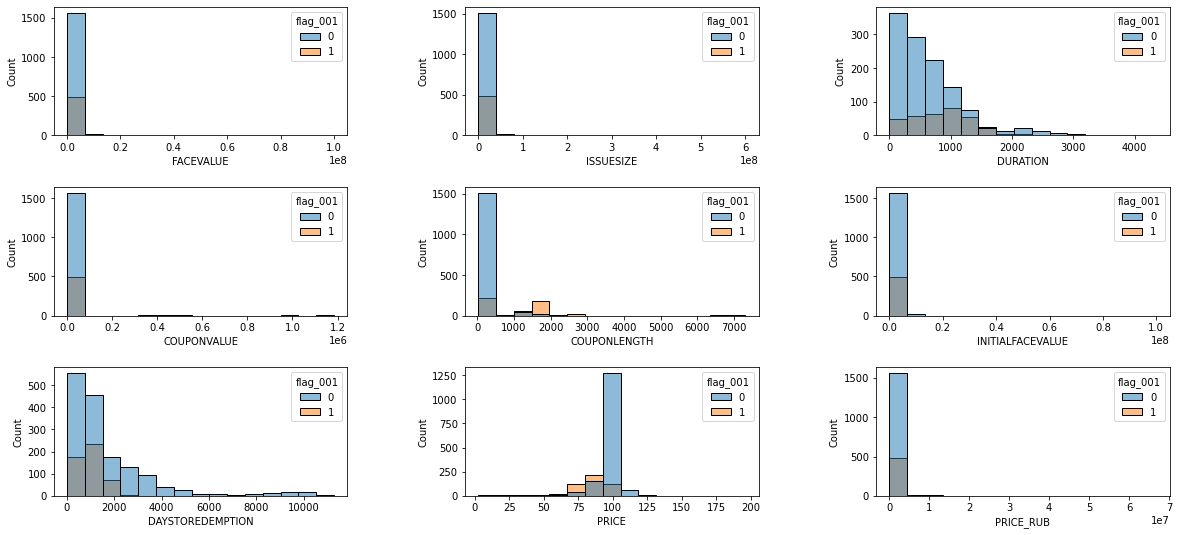

In [20]:
# Построим гистограммы числовых признаков с группировкой по новому флагу
fig = plt.figure(figsize=(20, 9))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, col in enumerate(num_col):
    plt.subplot(3, 3, i+1)
    sns.histplot(data = df, x=col, hue='flag_001', bins=15)

Видим, что у всех распределений длинные хвосты. Попробуем прологарифмировать.

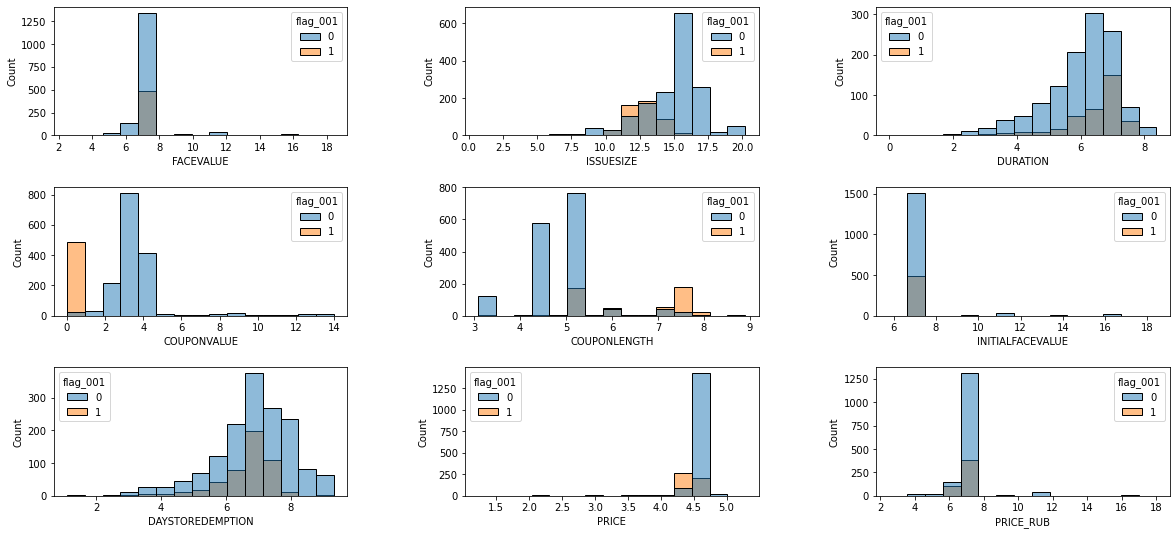

In [21]:
df_log = df[num_col + ['flag_001']].copy()
df_log[num_col] = df_log[num_col].apply(lambda x: np.log(x+1))

# Построим гистограммы числовых признаков с группировкой по новому флагу
fig = plt.figure(figsize=(20, 9))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, col in enumerate(num_col):
    plt.subplot(3, 3, i+1)
    sns.histplot(data = df_log, x=col, hue='flag_001', bins=15)

Видим, что у облигаций со ставкой купона 0.01% всегда маленькая сумма купона.

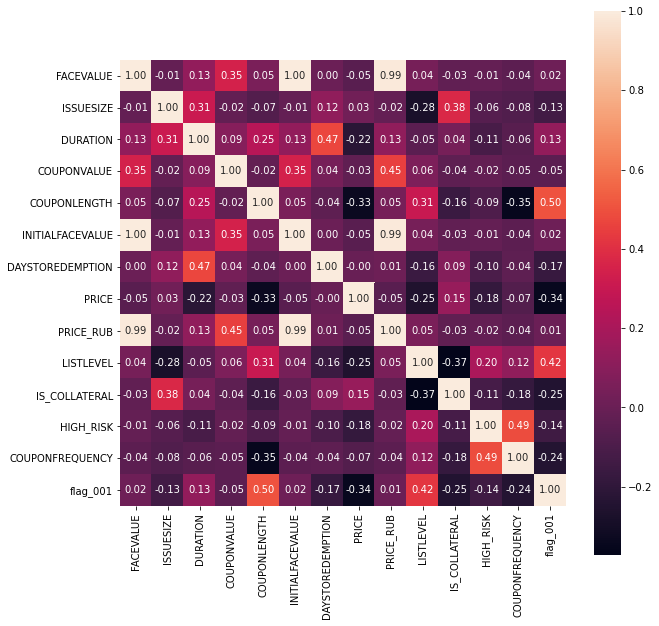

In [22]:
# Посмотрим на матрицу корреляций
plt.subplots(figsize=(10,10))
sns.heatmap(df[num_col + cat_col + ['flag_001']].corr(), fmt=".2f", annot=True, square=True)
plt.show()

Видим, что у введеного признака flag_001 достаточно сильная положительная корреляция с длиной купонного периода (COUPONLENGTH) и уровнем листинга (LISTLEVEL) и отрицательная корреляция с ценой в %% (PRICE).

<i>Корректно ли в дальнейшем разделить облигации на две группы по флагу flag_001 и рассматривать их отдельно?

Или корректно оценивать не непосредственно ставку купона, а перевести ее в годовую? Далее попробуем те же действия проделать с годовой ставкой.
</i>

In [23]:
# Ввдем новый признак - купонный доход за год и установим его в 0
df['YEAR_COUPONPERCENT'] = 0

In [24]:
current_date = datetime.now()

# Для облигаций без указания частоты выплаты купонов в год и датой погашения меньше, чем текущая дата + 365 дней, установим 
# значение купонного дохода за год, равным COUPONPERCENT

df['YEAR_COUPONPERCENT'] = df[['MATDATE','COUPONFREQUENCY','YEAR_COUPONPERCENT','COUPONPERCENT']].apply(lambda x: \
       x.COUPONPERCENT if (math.isnan(x.COUPONFREQUENCY)) & (x.MATDATE < current_date + timedelta(days=365)) \
       else x.YEAR_COUPONPERCENT, axis=1)

# Для облигаций, где указана частота выплаты купонов в год, посчитаем %% за год
df['YEAR_COUPONPERCENT'] = df[['MATDATE','COUPONFREQUENCY','YEAR_COUPONPERCENT','COUPONPERCENT']].apply(lambda x: \
       x.COUPONPERCENT * x.COUPONFREQUENCY if (not math.isnan(x.COUPONFREQUENCY)) \
       else x.YEAR_COUPONPERCENT, axis=1)

# Для облигаций без указания частоты выплаты купонов в год и датой погашения больше, чем текущая дата + 365 дней 
# значение купонного дохода за год остается равным 0

In [25]:
# Найдём выборочное среднее, дисперию, стандартное отклонение, медиану и моду.

mu = np.mean(df.YEAR_COUPONPERCENT)
var = np.var(df.YEAR_COUPONPERCENT)
std = np.std(df.YEAR_COUPONPERCENT)
median = np.median(df.YEAR_COUPONPERCENT)
moda = stats.mode(df.YEAR_COUPONPERCENT)[0][0]
print('Выборочное среднее = %.4f' % mu)
print('Дисперсия = %.4f' % var)
print('Стандартное отклонение = %.4f' % std)
print('Медиана = %.4f' % median)
print('Мода = %.4f' % moda)

Выборочное среднее = 26.1757
Дисперсия = 1338.5647
Стандартное отклонение = 36.5864
Медиана = 16.5000
Мода = 0.0000


In [26]:
# Посмотрим, много ли осталось облигаций с годовой купонной ставкой = 0

df.YEAR_COUPONPERCENT.value_counts().head(10)

0.00     321
0.02     171
0.01      74
52.00     24
48.00     22
19.00     20
14.00     17
44.00     17
30.00     16
34.00     15
Name: YEAR_COUPONPERCENT, dtype: int64

In [27]:
# Далее не будем рассматривать записи с годовой купонной ставкой = 0, 
# как не представляющие интереса с точки зрения получения купонного дохода

df_year = df[df.YEAR_COUPONPERCENT != 0].copy()

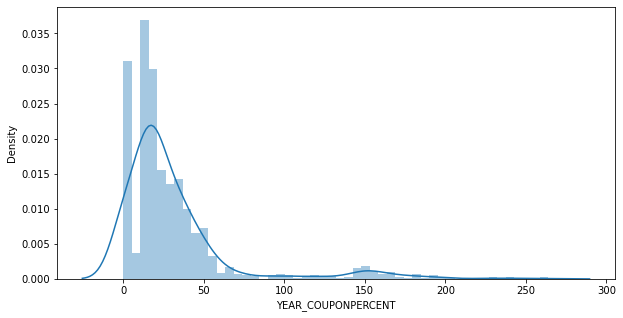

In [28]:
# Построим гистограмму и ядерную оценку плотности

fig = plt.figure(figsize=(10, 5))

sns.distplot(df_year.YEAR_COUPONPERCENT);

У распределения длинный хвост, попробуем прологарифмировать

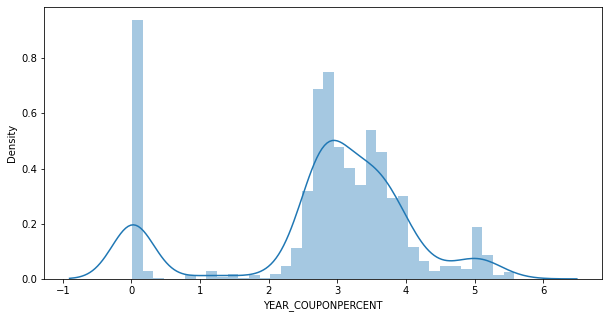

In [29]:
# Построим гистограмму и ядерную оценку плотности

fig = plt.figure(figsize=(10, 5))

sns.distplot(np.log(df_year.YEAR_COUPONPERCENT+1));

При рассмотрении годового купонного дохода также на распределении видим два максимума. Т.е. облигации со ставкой купона 0.01% это отдельная группа облигаций.

Посмотрим, как распределена ставка купона, не равная 0.01%

<AxesSubplot:ylabel='Density'>

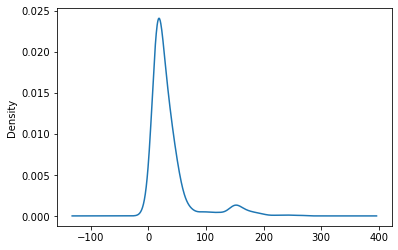

In [30]:
df_year[df_year.COUPONPERCENT != 0.01]['YEAR_COUPONPERCENT'].plot(kind='density')

<AxesSubplot:>

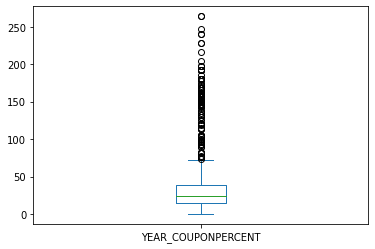

In [31]:
# Посмотрим на распределение на boxplot

df_year[df_year.COUPONPERCENT != 0.01].YEAR_COUPONPERCENT.plot(kind='box')

Видим очень много выбросов.

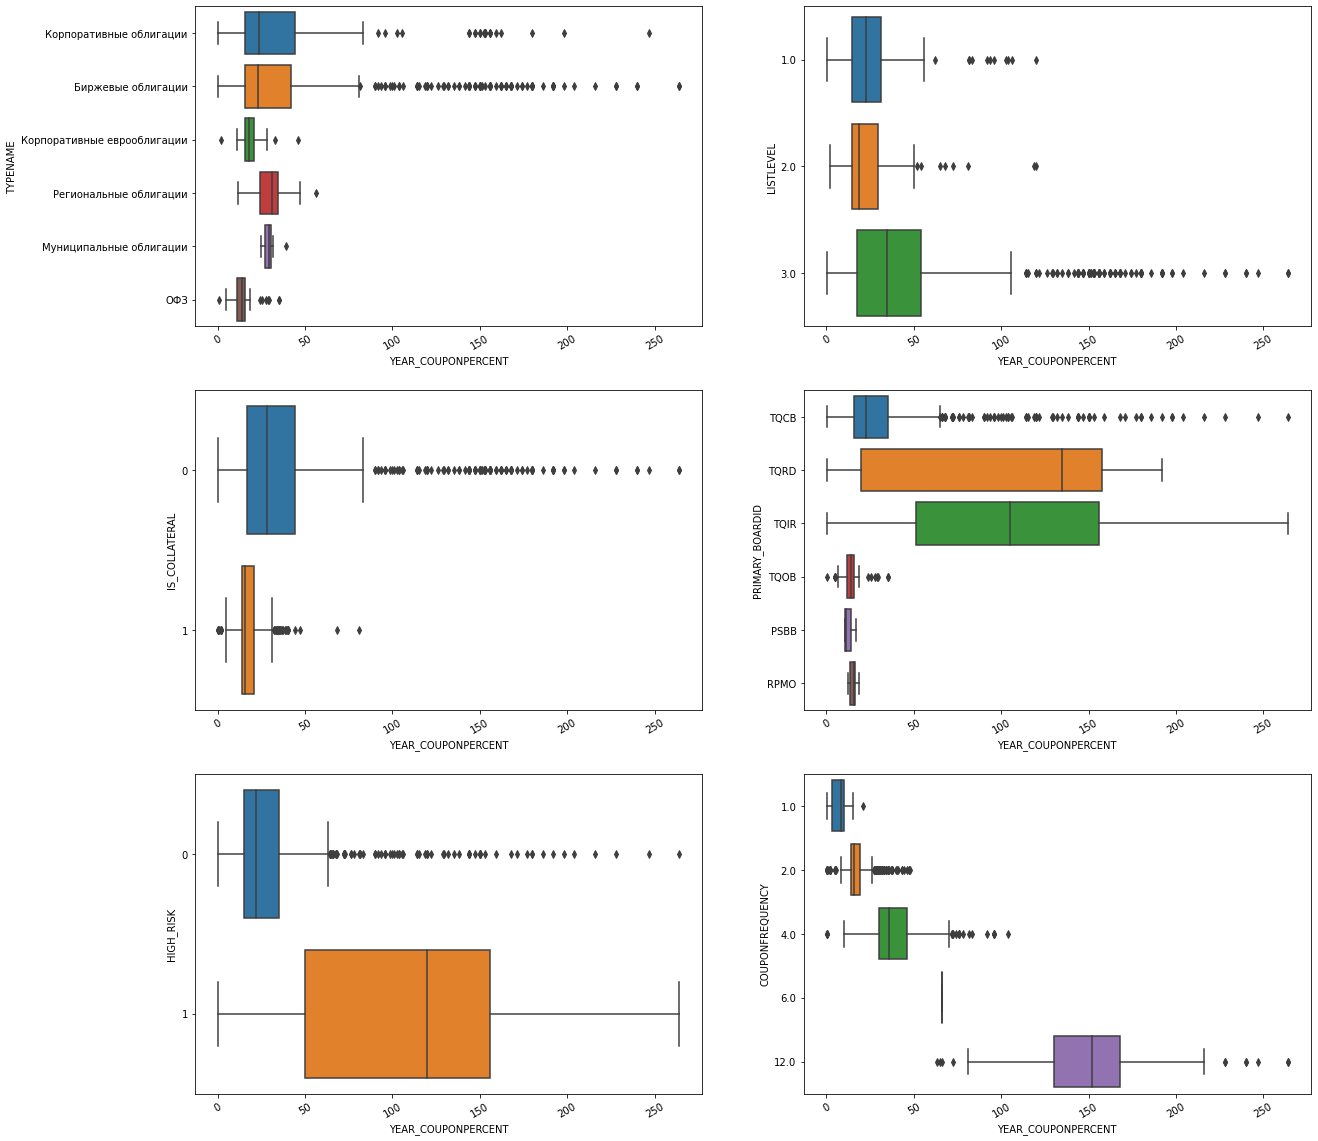

In [32]:
# Посмотрим на распределение на boxplot в зависимости от категориальных переменных

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i, col in enumerate(cat_col):
    plt.subplot(3,2,i+1)
    sns.boxplot(y=col, x='YEAR_COUPONPERCENT', data=df_year[df_year.COUPONPERCENT != 0.01], orient="h")
    plt.xticks(rotation=30)

Выбросов по-прежнему очень много, но наблюдаются они не везде. Медианы в разрезе некоторых категориальных признаков почти не отличаются. Явные отличия медианы и разброса ставки мы видим у признаков:
1. Наличие обеспечения (IS_COLLATERAL)
2. Уровень риска (HIGH_RISK)
3. PRIMARY_BOARDID
4. Для уровня листинга (LISTLEVEL) есть различие между (1+2) и 3. В дальшейшем ввдем новый признак is_LISTLEVEL3 для обучения модели
5. Частота выплаты купона (COUPONFREQUENCY)

### Предложить разделение на кластеры по купонной доходности

In [51]:
# Введем признак is_LISTLEVEL3
df_year['is_LISTLEVEL3'] = df_year['LISTLEVEL'].apply(lambda x: 1 if x==3 or np.isnan(x) else 0)

# Введем признак "Год выпуска"
df_year['ISSUE_year'] = df_year['ISSUEDATE'].apply(lambda x: x.year)

In [221]:
# Будем считать, что отдельный кластер - это скоуп облигаций со ставкой купона 0.01%. 
# Остальные попробуем разделить на кластеры с помощью метода k-Means

col_for_clasters = ['TYPENAME','is_LISTLEVEL3','IS_COLLATERAL','PRIMARY_BOARDID','HIGH_RISK','COUPONFREQUENCY','ISSUE_year',\
        'FACEVALUE','ISSUESIZE','DURATION','COUPONVALUE','COUPONLENGTH','INITIALFACEVALUE','DAYSTOREDEMPTION','PRICE',\
        'PRICE_RUB','YEAR_COUPONPERCENT']

bonds = df_year[df_year.COUPONPERCENT != 0.01][col_for_clasters]

# Удалим оставшиеся пропущенные значения
bonds = bonds.dropna()
bonds = bonds.reset_index()
bonds.head()

,index,TYPENAME,is_LISTLEVEL3,IS_COLLATERAL,PRIMARY_BOARDID,HIGH_RISK,COUPONFREQUENCY,ISSUE_year,FACEVALUE,ISSUESIZE,DURATION,COUPONVALUE,COUPONLENGTH,INITIALFACEVALUE,DAYSTOREDEMPTION,PRICE,PRICE_RUB,YEAR_COUPONPERCENT
0,13,Корпоративные облигации,0,1,TQCB,0,2.0,2009,1000.0,10000000.0,634.0,39.14,182.0,1000.0,673.0,99.64,1008.44,15.7
1,14,Корпоративные облигации,0,1,TQCB,0,2.0,2009,1000.0,7000000.0,241.0,83.18,184.0,1000.0,253.0,102.46,1075.68,33.0
2,15,Корпоративные облигации,0,1,TQCB,0,2.0,2009,1000.0,7000000.0,1283.0,100.82,184.0,1000.0,2203.0,106.43,1159.64,40.0
3,16,Корпоративные облигации,0,1,TQCB,0,2.0,2010,1000.0,15000000.0,800.0,39.14,182.0,1000.0,865.0,99.29,1002.79,15.7
4,17,Корпоративные облигации,0,0,TQCB,0,1.0,2010,875.0,8000000.0,911.0,60.21,364.0,1000.0,2248.0,87.98,819.62,6.9


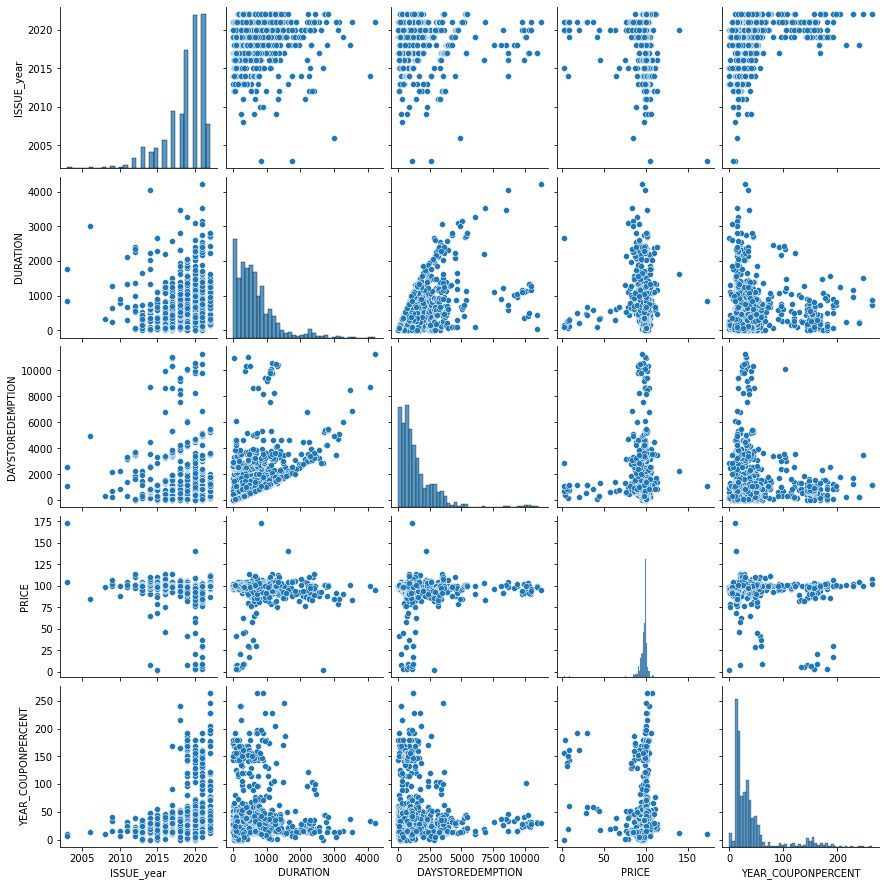

In [69]:
# Посмотрим на получившиеся данные визуально

sns.pairplot(bonds[['ISSUE_year','DURATION','DAYSTOREDEMPTION','PRICE','YEAR_COUPONPERCENT']])

На графиках визуально видно разделение данных на области по некоторым признакам

In [222]:
# Закодируем некоторые категориальные переменные

bonds = pd.get_dummies(bonds, columns=['TYPENAME','PRIMARY_BOARDID'], prefix=['TN', 'PB'])
bonds.head(3)

,index,is_LISTLEVEL3,IS_COLLATERAL,HIGH_RISK,COUPONFREQUENCY,ISSUE_year,FACEVALUE,ISSUESIZE,DURATION,COUPONVALUE,...,TN_Биржевые облигации,TN_Корпоративные еврооблигации,TN_Корпоративные облигации,TN_Муниципальные облигации,TN_ОФЗ,TN_Региональные облигации,PB_TQCB,PB_TQIR,PB_TQOB,PB_TQRD
0,13,0,1,0,2.0,2009,1000.0,10000000.0,634.0,39.14,...,0,0,1,0,0,0,1,0,0,0
1,14,0,1,0,2.0,2009,1000.0,7000000.0,241.0,83.18,...,0,0,1,0,0,0,1,0,0,0
2,15,0,1,0,2.0,2009,1000.0,7000000.0,1283.0,100.82,...,0,0,1,0,0,0,1,0,0,0


По методу локтя найдем оптимальное количество кластеров.

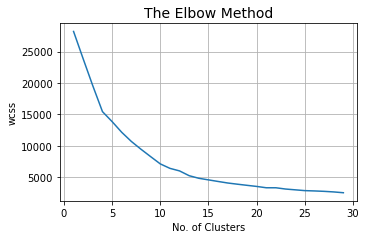

In [223]:
x = bonds.loc[:,bonds.columns[1:]]
# Нормализуем данные
X = StandardScaler().fit_transform(x)

wcss = []
for i in range(1, 30):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0,
                algorithm = 'elkan',
                tol = 0.001)
    
    km.fit(X)
    labels = km.labels_
    wcss.append(km.inertia_)
    
plt.rcParams['figure.figsize'] = (5, 3)
plt.plot(range(1, 30), wcss)
plt.grid()
plt.tight_layout()
plt.title('The Elbow Method', fontsize = 14)
plt.xlabel('No. of Clusters', fontsize = 10)
plt.ylabel('wcss', fontsize = 10)
plt.show()

Посмотрим, сильно ли уменьшится количество кластеров, если использовать только один признак YEAR_COUPONPERCENT

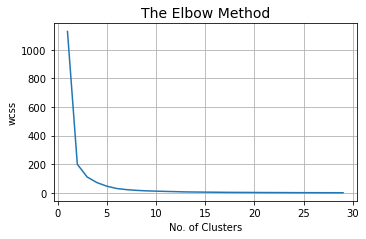

In [225]:
x = np.array(bonds.YEAR_COUPONPERCENT).reshape(-1, 1)
# Нормализуем данные
X = StandardScaler().fit_transform(x)

wcss = []
for i in range(1, 30):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0,
                algorithm = 'elkan',
                tol = 0.001)
    
    km.fit(X)
    labels = km.labels_
    wcss.append(km.inertia_)
    
plt.rcParams['figure.figsize'] = (5, 3)
plt.plot(range(1, 30), wcss)
plt.grid()
plt.tight_layout()
plt.title('The Elbow Method', fontsize = 14)
plt.xlabel('No. of Clusters', fontsize = 10)
plt.ylabel('wcss', fontsize = 10)
plt.show()

Если использовать только признак YEAR_COUPONPERCENT, то оптимальное количество кластеров = 5.

Далее будем использовать все признаки и считать, что оптимальное число кластеров = 15 + облигации со ставкой купона 0.01%. Обучим модель с гиперпараметром n_clusters = 15

In [256]:
x = bonds.loc[:,bonds.columns[1:]]
# Нормализуем данные
X = StandardScaler().fit_transform(x)

km = KMeans(n_clusters = 15, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0).fit(X)

#bonds.insert(0, 'Cluster Labels', km.labels_)
bonds['Cluster Labels'] = km.labels_
bonds.head()

,Cluster Labels,index,is_LISTLEVEL3,IS_COLLATERAL,HIGH_RISK,COUPONFREQUENCY,ISSUE_year,FACEVALUE,ISSUESIZE,DURATION,...,TN_Биржевые облигации,TN_Корпоративные еврооблигации,TN_Корпоративные облигации,TN_Муниципальные облигации,TN_ОФЗ,TN_Региональные облигации,PB_TQCB,PB_TQIR,PB_TQOB,PB_TQRD
0,7,13,0,1,0,2.0,2009,1000.0,10000000.0,634.0,...,0,0,1,0,0,0,1,0,0,0
1,7,14,0,1,0,2.0,2009,1000.0,7000000.0,241.0,...,0,0,1,0,0,0,1,0,0,0
2,7,15,0,1,0,2.0,2009,1000.0,7000000.0,1283.0,...,0,0,1,0,0,0,1,0,0,0
3,7,16,0,1,0,2.0,2010,1000.0,15000000.0,800.0,...,0,0,1,0,0,0,1,0,0,0
4,7,17,0,0,0,1.0,2010,875.0,8000000.0,911.0,...,0,0,1,0,0,0,1,0,0,0


In [257]:
# Получились кластеры
bonds['Cluster Labels'].value_counts()

11    204
0     161
8     159
14    155
5     106
7      78
13     55
4      54
12     44
3      44
2      27
10     15
6      15
9       6
1       5
Name: Cluster Labels, dtype: int64

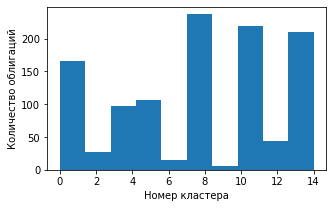

In [260]:
bonds['Cluster Labels'].plot(kind='hist')

plt.ylabel('Количество облигаций')
plt.xlabel('Номер кластера') 
plt.show()

In [ ]:
# Добавим номер кластера в основной датасет

bonds = bonds.set_index(['index'])

df_year['Cluster Labels'] = bonds['Cluster Labels']

# Для облигаций со ставкой купона 0.01% проставим кластер = -1
df_year['Cluster Labels'] = df_year[['COUPONPERCENT','Cluster Labels']].apply(lambda x: -1 if x.COUPONPERCENT == 0.01 \
                                        else x['Cluster Labels'], axis=1)

Посмотрим на кластеры на графике

Text(0.5, 1.0, 'MNIST. t-SNE projection')

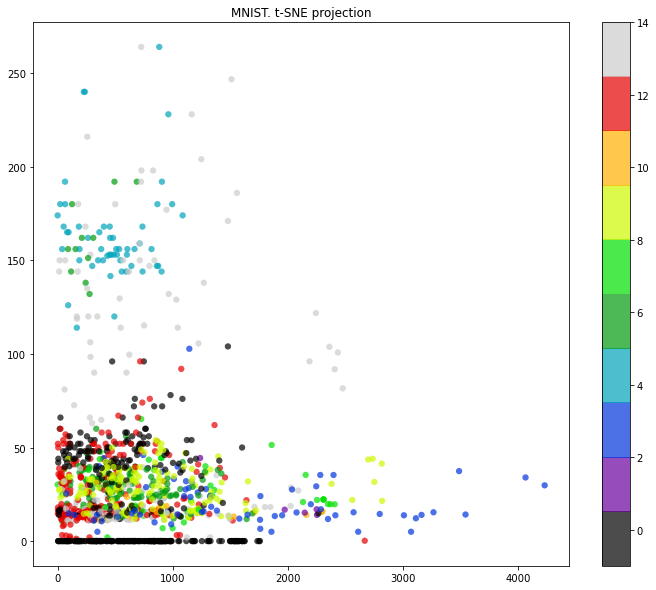

In [276]:
plt.figure(figsize=(12,10))
plt.scatter(df_year.DURATION, df_year.YEAR_COUPONPERCENT, c=df_year['Cluster Labels'],
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection')

<i>Не понятно, как можно использовать получившуюся информацию. Возможно нужно какие-то признаки преобразовать перед обучением модели.</i>